In [1414]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv

In [1415]:
WG = .02 # Defines how much wealth grows each period
TR = .3 #Tax Rate

In [1416]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [1417]:
def ppl0(): ##Setsup the first, 0th, generation
    w = np.random.randint(1,11,size=10)
    w.sort() # random wealth distrobution, 1-10, sorted
    ppl0 = pd.DataFrame({'Name': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], 'W': w}) #base values of the first generation
    ppl0['WRich'] = ppl0.apply(lambda row: True if row['W'] >= np.mean(ppl0.W) else False, axis=1) #Says if they are wealth rich, meaning above average
    ppl0['IRich'] = False #No income yet, they are all not income rich
    ppl0["Income"] = 0
    ppl0["Taxed"] = 0
    ppl0["SB"] = 0 #.1*(ppl0['W']/max(ppl0['W']))  #Random change buffer, higher value means higher avg expected draw. Is proportional to wealth compared to max
    ppl0["Vote"] = ppl0.apply(lambda row: False if row['WRich'] == True else True, axis=1) # Rich people vote no for redistrobution #will be based on probabilities and wealth later
    return ppl0


In [1418]:
def reset0(): ## Restarts all data
    ppl = [ppl0()] #creates list of generations of people
    elect = [False] #Creates a list that will collect all election outcomes
    G = [gini(ppl[0]['W'])]
    return ppl, elect, G

In [1419]:
ppl, elect, G = reset0()
ppl[0]

,Name,W,WRich,IRich,Income,Taxed,SB,Vote
0,A,2,False,False,0,0,0,True
1,B,4,False,False,0,0,0,True
2,C,4,False,False,0,0,0,True
3,D,4,False,False,0,0,0,True
4,E,5,False,False,0,0,0,True
5,F,5,False,False,0,0,0,True
6,G,6,True,False,0,0,0,False
7,H,6,True,False,0,0,0,False
8,I,8,True,False,0,0,0,False
9,J,10,True,False,0,0,0,False


In [1420]:
def NextPeriod():
    t = len(ppl) ## current period
    ppl.append(ppl[t - 1].copy()) ## creates copy of previous period
    
    Outcome = False #Outcome of vote is not to tax unless vote otherwise
    if ppl[t - 1]["Vote"].value_counts()[True] >= ppl[t - 1]["Vote"].value_counts()[False]: Outcome = True
    elect.append(Outcome)
    
    ppl[t]['Income'] = ppl[t]['W']*(WG) ## calculates income fro individual (wealth * wealth growth rate) 
    ppl[t]['Income'] = ppl[t].apply(lambda row: row['Income'] 
                        + (row['W'] * np.random.normal(loc=row['SB'], scale=.1)) #+ random chance income, proportional to wealth, adjusted buffer for wealth
                        + (sum(ppl[t-1]['Taxed']) * np.random.beta(a = 3, b = 3*(len(ppl[t]) - 1))), axis = 1) #+ benefits of taxes through investment, on average all the benefits of the tax are distributed #using beta distrobution
    ## I hope you know I am actually really claver for figuring out how to create a beta distrobution with a set mean
    MeanI = np.mean(ppl[t]['Income']) ## Defining Mean Wealth
    
    ppl[t]['IRich'] = ppl[t].apply(lambda row: True if row['Income'] >= MeanI else False, axis=1) #Says if they are income rich, meaning above average
    ppl[t]["Taxed"] = ppl[t].apply(lambda row: (row['Income'] - MeanI)*TR if row['IRich'] == True else 0, axis=1) #calculates how much was taxed
    
    ppl[t]['W'] = ppl[t]['W'] + ppl[t]['Income'] - ppl[t]["Taxed"] ## Adds income to 
    ppl[t]['W'] = ppl[t].apply(lambda row: max(1, row['W']), axis = 1) ## min wealth is 1
    
    MeanW = np.mean(ppl[t]['W']) ## Defining Mean Wealth
    ppl[t]['WRich'] = ppl[t].apply(lambda row: True if row['W'] >= MeanW else False, axis=1) #Says if they are rich, meaning above average
    ppl[t]["SB"] = 0 # irrelavent, too powerful #.1*(ppl[t]['W']/max(ppl[t]['W'])) #chance buffer proportional to wealth compared to max wealth
    ppl[t]["Vote"] = ppl[t].apply(lambda row: False if row['WRich'] == True else True, axis=1) # Rich people vote no for redistrobution #will be based on probabilities and wealth later
    
    G.append(gini(ppl[t]['W']))
    
    return t

In [1421]:
def GraphNextWealth():
    t = NextPeriod() #calls the function creating the next period and returns the current period t and voting outcome
    GraphW = sns.barplot(data=ppl[t], x="Name", y="W", estimator= 'mean', order = ppl[t].sort_values('W').Name) #Wealth distrobution graph
    GraphW.set(title = f"Wealth in Period {t}, Outcome is {elect[t]}, Gini is {G[t]:.3f}", label = True) #, ybound=[0,50],)
    GraphW.bar_label(GraphW.containers[0])
    GraphW.axhline(y = np.mean(ppl[t]['W']), color = 'darkgreen')

In [1422]:
#GraphNextWealth()

In [1423]:
def run(r = 100): #iterates for 100 periods
    for i in range(r): NextPeriod()

In [1424]:
def probF():
    isT = 0 #counts how many times the value is T
    stF = 0 #counts how many times T switches to F
    
    for i in range(len(elect)-1):
        if elect[i] == True: isT += 1
        if elect[i] == False and elect[i-1] == True: stF += 1
        
    return (stF/isT)

In [1425]:
def plotGini(): ## creates plot with election outcomes and gini over time
    plt.plot(elect)
    plt.plot(G)
    plt.xlabel(f"Period, t = {len(ppl) - 1}")
    plt.ylabel(f"Tax Policy in Effect = 1, Avg. Gini ({np.mean(G):.3f})")
    plt.title(f"Tax Rate =  {TR}, Probability of Switching = {probF():.3f}")

In [1426]:
#run(1000)
#plotGini()

In [1427]:
#probF()

In [1428]:
def AvgG():
    AvgG = pd.DataFrame({'TR': [], 'AvgG': []}) #Average Gini list
    for TTR in range(10):
        TR = TTR * .1
        ppl, elect, G = reset0() # reset
        run(100) # itterate 100 times
        
        AvgG.loc[len(AvgG)] = [TR, np.mean(G)] ## Adds avg to list for each iteration
        
    return AvgG

In [1429]:
def GraphAvgG():
    AvgGD = AvgG()
    GraphAG = sns.lineplot(data = AvgGD, x = AvgGD['TR'], y = AvgGD['AvgG'])
    GraphAG.set(ybound = [0,1])

In [1430]:
#GraphAvgG()

In [1431]:
def probFTR():
    probFTR = pd.DataFrame({'TR': [], 'ProbF': []}) #Average Gini list
    for TTR in range(10):
        TR = TTR * .1
        ppl, elect, G = reset0() # reset
        run(100) # itterate 100 times
        
        probFTR.loc[len(probFTR)] = [TR, probF()] ## Adds avg to list for each iteration
        
    return probFTR

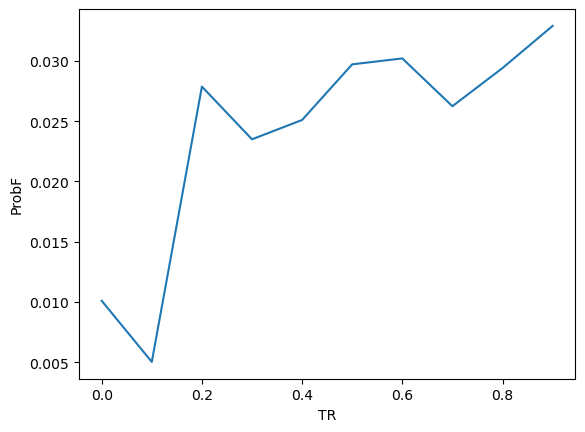

In [1432]:
probFD = probFTR()
GraphProbF = sns.lineplot(data = probFD, x = probFD['TR'], y = probFD['ProbF'])

In [1433]:
## Next
## Change voting to be based on percieved outcomes
## Delay voting / median Income, so probibility that they will be taxed in the period
## Calculate the inequality and making voting based on that
## collect the data and average over several times
## iterate over different r
## gini is actuallly good for measuring the distrobution but bad for advising next steps, or measuring the changes and directions of inequality
## Can change election laws, see impact
## Add more tax